In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
plt.rcParams["figure.figsize"] = (10,10) #change size of plots, values might need to be changed depending on your screen size https://towardsdatascience.com/change-figure-size-matplotlib-11a409f39584
plt.rcParams['figure.dpi'] = 100

## Stochasticity 
Previous integration methods, Euler and ODEINT from Scipy, were both deterministic methods. However, natural processes are rarely deterministic and are typically to some extent stochastic. It is important, however, to note that stochastic does not indicate random but simply that the process can best be described by a random distribution with a mean and variance, whereas deterministic processes are described solely by a mean with a variance equal to zero.



### Gillespie algorithm
The simplest and most common method to allow for stochastic simulation of systems of ODEs is the Gillespie algorithm. The basic idea of the Gillespie algorithm is that when and which event occurs is determined by a probability informed by the rates of these events. 


<img src="gillespie_diagram.PNG"
     alt="Markdown Monster icon"
     style="float: center; margin-center: 100px;width:500px" />
     
     

Original gillespie paper: https://www.sciencedirect.com/science/article/pii/0021999176900413

#### Gillespie in practice: Logistic growth

Consider the logistic growth differential equation:  
$$ {dN \over dt} = {r N (1-{N \over K})} $$ 
$$ or $$
$$ {dN \over dt} = {r N -r{N^2 \over K}} $$

To implement the gillespie algorithm, we have to first break up the ODE in its events and corresponding rates:  

||Events|Rates|
|-------------------|-------------------|-----------------|
|1|$N$ &rarr; $N$ + 1 | $rN$|
|2|$N$ &rarr; $N$ - 1 | $$rN^2 \over K$$|

Given these events and rates, let's now first calculate the time untill the next event, $\tau$:
    
$$ {\tau} = {1 \over R_{tot}} . ln \left({1 \over r_1} \right) $$  
  
<center>with $R_1$ being a random number between 0 and 1  
    and $R_{tot} = \sum_{i=1}^{I} Rates_{i} $<center>  
    
&nbsp;    
Let's plot the distribution of $\tau$ for different $R_{tot}$ values to show how $R_{tot}$ effects the distribution:

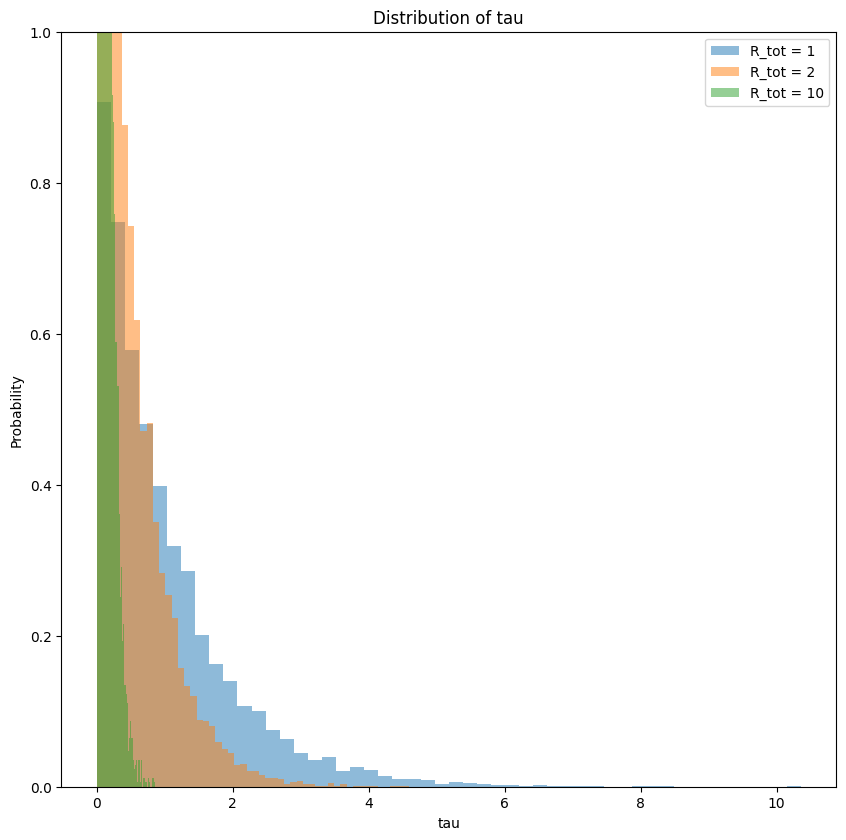

In [19]:
R_sum_list=[1,2,10]
for R_sum in R_sum_list:
    tau_list=[]
    for i in range(10000):
        rand_time = np.random.uniform()
        
        tau = 1/(R_sum) * np.log(1/rand_time)
        tau_list.append(tau)

    n, bins, patches = plt.hist(tau_list, 50, density=True,  alpha=0.5,label='R_tot = '+str(R_sum))
plt.xlabel('tau')
plt.ylabel('Probability')
plt.title('Distribution of tau')
plt.legend()
plt.ylim(0,1)
plt.show()

So the time until the next event is shorter as the sum of the rates increases. 

Now choose the next event to be updated. The probability of a specific event occuring again depends on its rates: 
  
$$ P(Event_1)={Rate_1 \over R_{tot}} = {rN \over R_{tot}}$$

$$ P(Event_2)={Rate_2 \over R_{tot}}= {{rN^2 \over K} \over R_{tot}} $$
  
Simply, we are taking a random draw of the events but wheighting their probability based on their rates.

Programmatically, we can do this by drawing a random number,$r_2$, from the interval [0,1] and then evaluating whether $r_2$ is smaller than P(Event_1) or not.

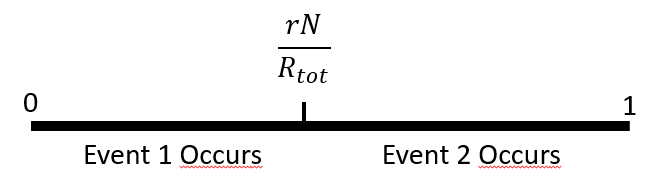

Lets again try to visualize this choice:

Theoretical P(Event1) = 0.6666666666666666
Simulated P(Event1) = 0.6689


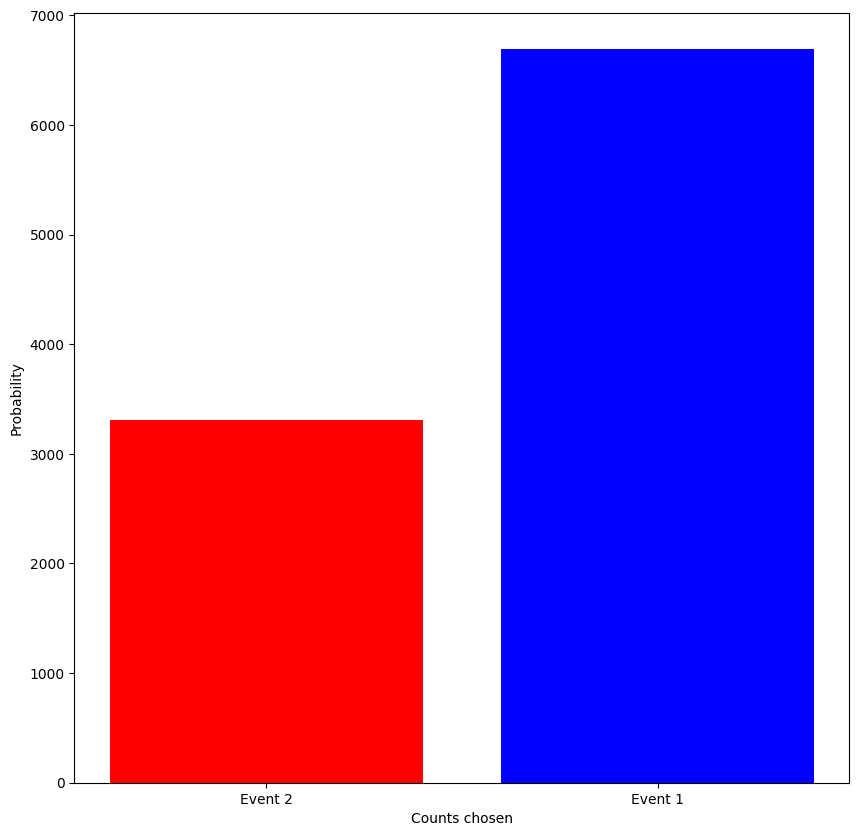

In [3]:

import time
from IPython import display


Event1_chosen=0
Event2_chosen=0
for n in range(10000):
    
    Rate_lists=[2,1] #lets assume a two event ODE with rate1=2 and rate2=1
    R_sum=np.sum(Rate_lists)
    randnum_reaction=np.random.uniform()
    
    if randnum_reaction <= Rate_lists[0]/R_sum:
        Event1_chosen+=1
        plt.bar('Event 1', Event1_chosen, align='center', alpha=1,color='b',label='Event 1')
        
    else:
        Event2_chosen+=1
        plt.bar('Event 2', Event2_chosen, align='center', alpha=1,color='r',label='Event 2')
        
    
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    #time.sleep(0.00001)

    plt.xlabel('Counts chosen')
    plt.ylabel('Probability')

print('Theoretical P(Event1) = '+str(Rate_lists[0]/R_sum))
   
print('Simulated P(Event1) = '+str(Event1_chosen/(Event2_chosen+Event1_chosen)))



Lets now put everything together and simulate logistic growth using the Gillespie algorithm.

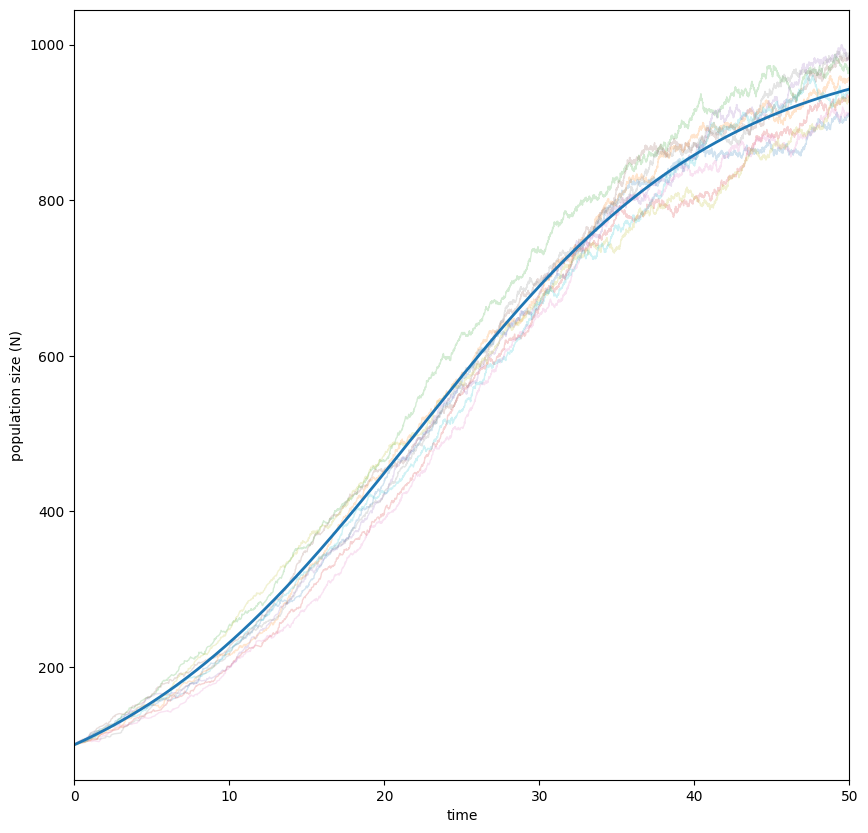

In [4]:
plt.rcParams["figure.figsize"] = (10,10) #change size of plots, values might need to be changed depending on your screen size https://towardsdatascience.com/change-figure-size-matplotlib-11a409f39584
plt.rcParams['figure.dpi'] = 100


def log_gillespie():
    N0=100
    r=0.1
    K=1000
    time_end=50

    time_start=0
    N_list=[(N0,time_start)]
    
    while N_list[-1][1]<=time_end:
        N_current=N_list[-1][0]
        Rate_lists=[r*N_current,r*(N_current**2)/K]
        R_sum=np.sum(Rate_lists) #sum of all the rates
        
        #determine time to next reaction
        
        rand_time = np.random.random()
        tau = 1/(R_sum) * np.log(1/rand_time)
        time = N_list[-1][1]+tau

        #Alternative method of selecting tau
        #time = N_list[-1][1] + np.random.exponential(1/R_sum) # or use prebuild numpy function to select tau

        
        #determine which event is updated. Birth +1 , Death -1
        rand_raction = np.random.uniform()
        if rand_raction <= Rate_lists[0]/R_sum:
            N_t_1 = N_current+1
        else:
            N_t_1 = N_current-1

        #Alternative method of selecting event
        #N_t_1 = N_current+np.random.choices([+1,-1], [Rate_lists[0]/R_sum,Rate_lists[1]/R_sum])[0]

        
        N_list.append((N_t_1,time))
    return N_list


    
#Lets compare the Gillespie simulation of logistic growth with the Euler integration.
for n in range(10):
    y=log_gillespie()
    N,time=np.array(y).T
    plt.plot(time,N,linewidth=1.0,alpha=0.2)

    
#Euler integration
dt=0.1
N0=100
r=0.1
K=1000
time_end=50
time_start=0
N_list_Euler_deterministic=[(N0,time_start)]
while N_list_Euler_deterministic[-1][1]<=time_end:

    N_current=N_list_Euler_deterministic[-1][0] #N0 is here current N, not the initial starting value
    N_t_1=N_current+r*(1-(N_current/K))*N_current*dt
    
    time=N_list_Euler_deterministic[-1][1]+dt
    
    N_list_Euler_deterministic.append((N_t_1,time))
    
N,time=np.array(N_list_Euler_deterministic).T
plt.plot(time,N,label='Euler method',linewidth=2.0,alpha=1)
plt.xlim(0,time_end)
plt.xlabel('time')
plt.ylabel('population size (N)')
plt.show()

### Further reading
http://be150.caltech.edu/2019/handouts/12_stochastic_simulation_all_code.html

## Other stochastic solver (WIP)

### Euler-Maruyama method
https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method

In [108]:
def logistic_EMmethod(N0,r,K,dt,sigma,time_end):

    steps=int(time_end/dt)
    time_start=0
    N_list=[(N0,time_start)]

    for n in range(steps):

        N_current=N_list[-1][0]
        N_t_1=N_current+r*N_current*(1-N_current/K)*dt + sigma*np.sqrt(dt)*np.random.normal(loc=0.0, scale=1) #Euler + random white noise with size sigma

        time=N_list[-1][1]+dt

        N_list.append((N_t_1,time))

        n=n+1
        if N_list[-1][1]>=time_end:
            break #breaks the for loop and ends the simulation
    return N_list

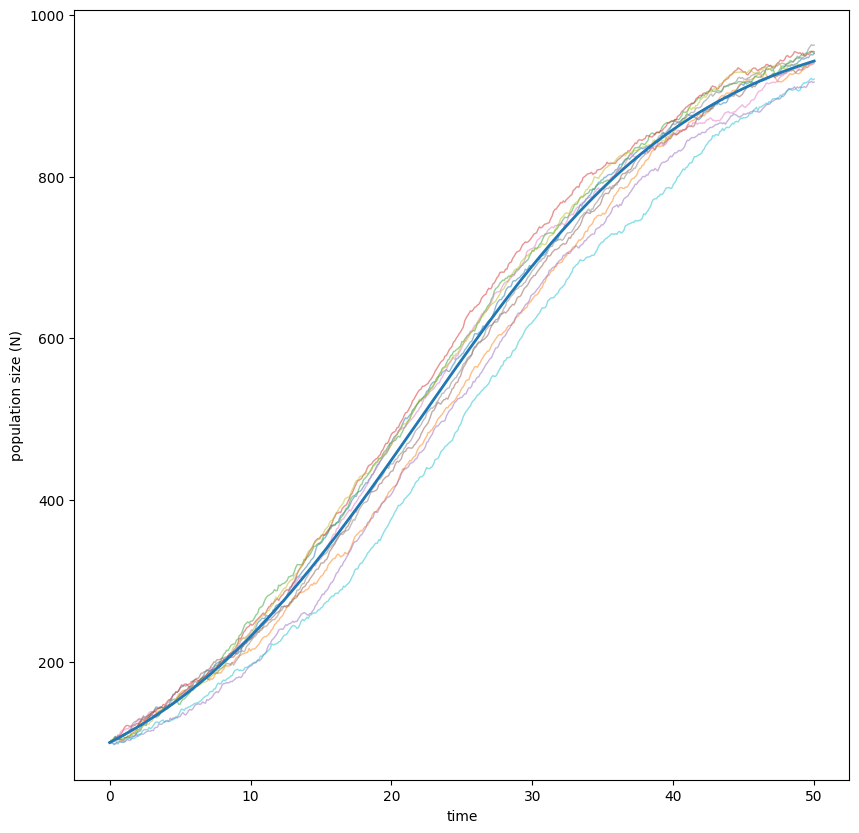

In [112]:
for i in range(10):
    N_list=logistic_EMmethod(100,0.1,1000,0.1,5,50)
    
    N,time=np.array(N_list).T
    plt.plot(time,N,linewidth=1.0,alpha=0.5)
    plt.xlabel('time')
    plt.ylabel('population size (N)')
    
N_list_Euler_deterministic=[(100,0)]
K=1000
r=0.1
while N_list_Euler_deterministic[-1][1]<=time_end:

    N_current=N_list_Euler_deterministic[-1][0] #N0 is here current N, not the initial starting value
    N_t_1=N_current+r*(1-(N_current/K))*N_current*dt
    
    time=N_list_Euler_deterministic[-1][1]+dt
    
    N_list_Euler_deterministic.append((N_t_1,time))
    
N,time=np.array(N_list_Euler_deterministic).T
plt.plot(time,N,label='Euler method',linewidth=2.0,alpha=1)
plt.show()
